## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import random
import pprint,time
from nltk.tokenize import word_tokenize

In [2]:
#To download the treebank corpus if not available
#nltk.download('treebank')

In [3]:
#To download the universal tagset if not available in the system
#nltk.download('universal_tagset')

In [4]:
#Reading the Treebank dataset of NLTK with universal tagset
#The Universal tagset of NLTK comprises only 12 coarse tag classes as follows: 
#Verb, Noun, Pronouns, Adjectives, Adverbs, Adpositions, Conjunctions, Determiners, Cardinal Numbers, Particles, Other/ Foreign words, Punctuations.
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [5]:
#Length of the dataset
len(nltk_data)

3914

In [6]:
#Viewing the first 5 sentences of the treebank dataset
nltk_data[:5]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

##### Train-Test Splitup

In [7]:
#Train-Test split up on the dataset
#sample size of 95:5
#keeping the validation size small, else the algorithm will need a very high amount of runtime.
random.seed(1234)
train_set,validation_set = train_test_split(nltk_data,test_size=0.05,random_state=101)

In [8]:
#Length of the train set
print(len(train_set))

3718


In [9]:
#Length of the test/validation set
print(len(validation_set))

196


Now we can get each pair of tagged word and the corresponding tag from the train set,seperately into a list

In [10]:
tagged_words_from_train = [pair for sent in train_set for pair in sent]

In [11]:
len(tagged_words_from_train)

95547

Hence, there are about 95547 words tagged(where same word can occur rerepeatedly), present in the train set.

In [12]:
#Tokens - All the words of the tagged train set
token = [pair[0] for pair in tagged_words_from_train]

In [13]:
print(token[:10])

['Reliance', 'confirmed', 'the', 'filing', 'but', 'would', "n't", 'elaborate', '.', '*']


So we know,the vocabulary in hand would be the distinct words of the dataset. We can find out that now.

In [14]:
vocab = set(token)

In [15]:
len(vocab)

12100

So, we are having <b> 12100 </b> words in hand from our train dataset.

In [16]:
# number of tags
T = set([pair[1] for pair in tagged_words_from_train])

In [17]:
len(T)

12

In [18]:
print(T)

{'.', 'X', 'VERB', 'ADV', 'CONJ', 'NOUN', 'PRON', 'NUM', 'ADJ', 'DET', 'PRT', 'ADP'}


So all the words of the train set of the treebank are tagged with any of the above tags.

#### Transition and Emission Probabilities

We know that the `emission probability` of a word 'w' for tag 't' is given by - <br>
<b> P(w|t) = Number of times w has been tagged t / Number of times t appear </b> <br>
Hence we will try implementing the same using below function.

In [19]:
#Computing the Emission Probability
def word_given_tag(word,tag,train_bag=tagged_words_from_train):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag_list = len(w_given_tag_list)
    return(count_w_given_tag_list,count_tag)

In [20]:
#We can just see an example for emission probability say for word - 'large' given tag - 'Adjective'
word_given_tag('large','ADJ')

(28, 6069)

The output indicates out of 6069 adjective tags present in the train bag, 28 times word large has been tagged as adjective.

We know that the `transition probability` of tag t1 followed by tag t2 is given by - <br>
<b> P(t2|t1) = No. of times t1 is followed by tag t2 / Number of times t1 appear </b> <br>
Hence we will try implementing the same using below function.

In [21]:
#Computing the Transition Probability
def t2_given_t1(t2,t1,train_bag=tagged_words_from_train):
    tags=[pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1]==t2:
            count_t2_t1 += 1
    return(count_t2_t1,count_t1)

In [22]:
#We can just see an example for transition probability say for verb followed by a adverb
t2_given_t1('ADV','VERB')

(1058, 12910)

In [23]:
#We can just see an example for transition probability say for verb followed by an adjective
t2_given_t1('ADJ','VERB')

(839, 12910)

#### Creation of a transition probability matrix

In [24]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [25]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [26]:
#tags_df is the dataframe with trainsition probabilities
tags_df

,.,X,VERB,ADV,CONJ,NOUN,PRON,NUM,ADJ,DET,PRT,ADP
.,0.093320,0.026971,0.089095,0.052324,0.057538,0.222242,0.066349,0.081003,0.043963,0.173335,0.002427,0.091342
X,0.163590,0.076384,0.203851,0.024984,0.010662,0.062381,0.055538,0.002864,0.017187,0.054742,0.185232,0.142584
VERB,0.034934,0.217506,0.169249,0.081952,0.005577,0.110070,0.035786,0.022851,0.064988,0.134392,0.030674,0.092022
ADV,0.137131,0.023186,0.343491,0.080490,0.006956,0.031467,0.014906,0.030474,0.129182,0.069891,0.014243,0.118582
CONJ,0.034868,0.008833,0.156671,0.055323,0.000465,0.349140,0.058113,0.039981,0.118085,0.121339,0.004649,0.052534
NOUN,0.240604,0.029175,0.147667,0.017074,0.042666,0.263564,0.004607,0.009542,0.012248,0.012942,0.043397,0.176514
PRON,0.040965,0.089969,0.485452,0.034074,0.005360,0.210949,0.007657,0.006508,0.073124,0.009954,0.013017,0.022971
NUM,0.117332,0.210542,0.018761,0.002978,0.013699,0.350208,0.001489,0.184932,0.034247,0.003276,0.026504,0.036033
ADJ,0.063931,0.021091,0.011699,0.004778,0.016971,0.699621,0.000330,0.021256,0.066403,0.004943,0.010710,0.078267
DET,0.017993,0.045405,0.039850,0.012438,0.000483,0.638087,0.003744,0.022220,0.204323,0.005676,0.000242,0.009540


We can now go ahead and plot a heatmap for the same and find out if any patterns are present.

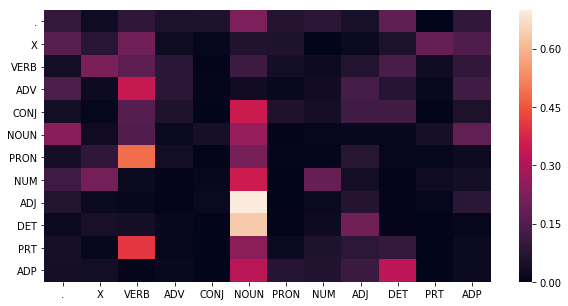

In [27]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(10,5))
sns.heatmap(tags_df)
plt.show()

We can see that there is a very high correlation between Adjective and a Noun happening together and also for the pair of Determinant and a Noun.

### Build the vanilla Viterbi based POS tagger

With the transition probability matrix in hand and Emission probability function we can go ahead and implement Viterbi Heuristic with the below function.

In [28]:
# Viterbi Heuristic
def Viterbi(words, train_bag = tagged_words_from_train):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Solve the problem of unknown words

#### METHOD 1 -> Considering Transition Probabilities alone

We know that,with the vanilla Viterbi model, we are calculating the state probability with the emission probability and transition probability together. But the issue here is that, if an unknown word is come across, the emission probability would be zero, since the word is not present in the training corpus. Hence for POS tagging, a random tag is then assigned, hence reducing the accuracy. <br>
Hence what we can do as a work around for this issue is that, for all the unknown words we can consider only the transition probability hence bringing in more accuracy to the Vanilla Viterbi function. <br>
The same has been implemented as with the below function where we are modified the function to have a check whether the word is present in our vocab, if then only going ahead with the emission-transtion together pair.

In [29]:
# Modified Viterbi Heuristic
def Viterbi_modified1(words, train_bag = tagged_words_from_train):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    vocab = list(set([pair[0] for pair in train_bag]))
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            #Compute emission and state probabilities
            #Here we are modifying the function such that, the emission probability is calculated only if the given word is present
            #in the tree bank test dataset.If not present,the state probability is taken as transition probability alone,since we
            #know the emission probabiliy will be zero for unknown words.
            if words[key] in vocab:
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p   
            else:
                state_probability = transition_p
            p.append(state_probability)
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

Since our validation set is 196 sentences long, running on entire dataset is time consuming, Hence we can measure the accuracy on a random set pulled out from this validation dataset.

In [30]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset
random.seed(1234)
# choose random 5 sents
rndom = [random.randint(1,len(validation_set)) for x in range(10)]
# list of sents
test_run = [validation_set[i] for i in rndom]
# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]
# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
print(test_run)

[[('The', 'DET'), ('Contra', 'NOUN'), ('military', 'ADJ'), ('command', 'NOUN'), (',', '.'), ('in', 'ADP'), ('a', 'DET'), ('statement', 'NOUN'), ('from', 'ADP'), ('Honduras', 'NOUN'), (',', '.'), ('said', 'VERB'), ('0', 'X'), ('Sandinista', 'NOUN'), ('troops', 'NOUN'), ('had', 'VERB'), ('launched', 'VERB'), ('a', 'DET'), ('major', 'ADJ'), ('offensive', 'NOUN'), ('against', 'ADP'), ('the', 'DET'), ('rebel', 'NOUN'), ('forces', 'NOUN'), ('.', '.')], [('*-1', 'X'), ('Bucking', 'VERB'), ('the', 'DET'), ('market', 'NOUN'), ('trend', 'NOUN'), (',', '.'), ('an', 'DET'), ('issue', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('from', 'ADP'), ('Detroit', 'NOUN'), (',', '.'), ('Mich.', 'NOUN'), (',', '.'), ('apparently', 'ADV'), ('drew', 'VERB'), ('solid', 'ADJ'), ('investor', 'NOUN'), ('interest', 'NOUN'), ('.', '.')], [('Ralston', 

In [31]:
print(test_tagged_words)

['The', 'Contra', 'military', 'command', ',', 'in', 'a', 'statement', 'from', 'Honduras', ',', 'said', '0', 'Sandinista', 'troops', 'had', 'launched', 'a', 'major', 'offensive', 'against', 'the', 'rebel', 'forces', '.', '*-1', 'Bucking', 'the', 'market', 'trend', ',', 'an', 'issue', 'of', '$', '130', 'million', '*U*', 'general', 'obligation', 'distributable', 'state', 'aid', 'bonds', 'from', 'Detroit', ',', 'Mich.', ',', 'apparently', 'drew', 'solid', 'investor', 'interest', '.', 'Ralston', 'said', '0', 'its', 'Eveready', 'battery', 'unit', 'was', 'hurt', '*-1', 'by', 'continuing', 'economic', 'problems', 'in', 'South', 'America', '.', 'I', 'feel', 'pretty', 'good', 'about', 'it', '.', 'Mr.', 'Felten', 'said', ',', '``', 'We', 'got', 'what', '*T*-252', 'amounted', 'to', 'a', 'parking', 'ticket', ',', 'and', 'by', '*-1', 'complaining', 'about', 'it', ',', 'we', 'ended', 'up', 'with', 'a', 'sizable', 'fine', 'and', 'suspension', '.', "''", 'U.S.', 'News', "'", 'circulation', 'in', 'the',

`test_tagged_words` is the list of words which we are passing into the modified Viterbi as well as the Vanilla Vitebi to check for the accuracy improvement and performance.

In [32]:
# tagging the test sentences
start = time.time()
tagged_seq_Vit_mod = Viterbi_modified1(test_tagged_words)
end = time.time()
difference = end-start

In [33]:
print("Time taken in seconds: ", difference)
print(tagged_seq_Vit_mod)

Time taken in seconds:  70.87277460098267
[('The', 'DET'), ('Contra', 'NOUN'), ('military', 'ADJ'), ('command', 'VERB'), (',', '.'), ('in', 'ADP'), ('a', 'DET'), ('statement', 'NOUN'), ('from', 'ADP'), ('Honduras', 'DET'), (',', '.'), ('said', 'VERB'), ('0', 'X'), ('Sandinista', 'VERB'), ('troops', 'NOUN'), ('had', 'VERB'), ('launched', 'VERB'), ('a', 'DET'), ('major', 'ADJ'), ('offensive', 'NOUN'), ('against', 'ADP'), ('the', 'DET'), ('rebel', 'NOUN'), ('forces', 'NOUN'), ('.', '.'), ('*-1', 'X'), ('Bucking', 'VERB'), ('the', 'DET'), ('market', 'NOUN'), ('trend', 'NOUN'), (',', '.'), ('an', 'DET'), ('issue', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('from', 'ADP'), ('Detroit', 'NOUN'), (',', '.'), ('Mich.', 'NOUN'), (',', '.'), ('apparently', 'ADV'), ('drew', 'VERB'), ('solid', 'ADJ'), ('investor', 'NOUN'), ('interest

In [34]:
# accuracy
check_Vit_mod = [i for i, j in zip(tagged_seq_Vit_mod, test_run_base) if i == j] 

In [35]:
accuracy_Vit_mod = len(check_Vit_mod)/len(tagged_seq_Vit_mod)

In [36]:
accuracy_Vit_mod

0.9484978540772532

<b> Hence we are getting an accuracy of `94.85%` with the modified Viterbi function with the approach of considering only Transition probability. 

In [37]:
incorrect_tagged_cases_Vit_mod = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_Vit_mod, test_run_base)) if j[0]!=j[1]]

In [38]:
#Below given are the incorrect tagged cases.
incorrect_tagged_cases_Vit_mod

[[('military', 'ADJ'), (('command', 'VERB'), ('command', 'NOUN'))],
 [('from', 'ADP'), (('Honduras', 'DET'), ('Honduras', 'NOUN'))],
 [('0', 'X'), (('Sandinista', 'VERB'), ('Sandinista', 'NOUN'))],
 [('its', 'PRON'), (('Eveready', 'VERB'), ('Eveready', 'NOUN'))],
 [('what', 'PRON'), (('*T*-252', 'VERB'), ('*T*-252', 'X'))],
 [('ended', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))],
 [('was', 'VERB'), (('2,303,328', 'X'), ('2,303,328', 'NUM'))],
 [('down', 'ADV'), (('2.6', 'VERB'), ('2.6', 'NUM'))],
 [('battle', 'NOUN'), (('opens', 'NOUN'), ('opens', 'VERB'))],
 [('0', 'X'), (('that', 'ADP'), ('that', 'DET'))],
 [('our', 'PRON'), (('borrowing', 'VERB'), ('borrowing', 'NOUN'))],
 [('borrowing', 'NOUN'), (('schedule', 'X'), ('schedule', 'NOUN'))]]

#### METHOD 2 -> Using a Rule-Based (Regular Expression) Tagger for Unknown words

We can define a rule based tagger function where we can define some general patterns and corresponding tags. <br>
The patterns we are defining include gerund,past tense,possessive nouns, cardinal numbers etc. <br>
if none of the above rules are applicable to a word, we tag a frequent tag NN.

In [39]:
#We can define a rule based tagger function where we can define some general patterns and corresponding tags.
def rule_based_tagger_func(word):
    new_list = []
    new_list.append(word)
    patterns = [
    (r'.*ing$', 'VERB'),                # gerund
    (r'.*ed$', 'VERB'),                 # past tense
    (r'.*es$', 'VERB'),                 # 3rd singular present
    (r'.*\'s$', 'NOUN'),                # possessive nouns
    (r'.*s$', 'NOUN'),                  # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),   # cardinal numbers
    (r'.*', 'NOUN')                     # nouns
    ]
    regexp_tagger = nltk.RegexpTagger(patterns)
    tag = regexp_tagger.tag(new_list)
    return tag[0][1]

In [40]:
# Modified Viterbi Heuristic
def Viterbi_modified2(words, train_bag = tagged_words_from_train):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p   
            
            p.append(state_probability)
        pmax = max(p)
        if pmax ==0:
            #pmax will be zero for unknown words. Hence for unknown words we are calling the rule_based_tagger_func
            state_max = rule_based_tagger_func(words[key])
        else:
        # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [41]:
# tagging the test sentences
start = time.time()
tagged_seq_Vit_mod2 = Viterbi_modified2(test_tagged_words)
end = time.time()
difference = end-start

In [42]:
print("Time taken in seconds: ", difference)
print(tagged_seq_Vit_mod2)

Time taken in seconds:  76.24870324134827
[('The', 'DET'), ('Contra', 'NOUN'), ('military', 'ADJ'), ('command', 'VERB'), (',', '.'), ('in', 'ADP'), ('a', 'DET'), ('statement', 'NOUN'), ('from', 'ADP'), ('Honduras', 'NOUN'), (',', '.'), ('said', 'VERB'), ('0', 'X'), ('Sandinista', 'NOUN'), ('troops', 'NOUN'), ('had', 'VERB'), ('launched', 'VERB'), ('a', 'DET'), ('major', 'ADJ'), ('offensive', 'NOUN'), ('against', 'ADP'), ('the', 'DET'), ('rebel', 'NOUN'), ('forces', 'NOUN'), ('.', '.'), ('*-1', 'X'), ('Bucking', 'VERB'), ('the', 'DET'), ('market', 'NOUN'), ('trend', 'NOUN'), (',', '.'), ('an', 'DET'), ('issue', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('from', 'ADP'), ('Detroit', 'NOUN'), (',', '.'), ('Mich.', 'NOUN'), (',', '.'), ('apparently', 'ADV'), ('drew', 'NOUN'), ('solid', 'ADJ'), ('investor', 'NOUN'), ('interes

In [43]:
# accuracy
check_Vit_mod2 = [i for i, j in zip(tagged_seq_Vit_mod2, test_run_base) if i == j] 

In [44]:
accuracy_Vit_mod2 = len(check_Vit_mod2)/len(tagged_seq_Vit_mod2)

In [45]:
accuracy_Vit_mod2

0.9656652360515021

<b> Hence we are getting an accuracy of `96.57%` with the modified Viterbi function with a combination of regular expression tagger.

In [46]:
incorrect_tagged_cases_Vit_mod2 = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_Vit_mod2, test_run_base)) if j[0]!=j[1]]

In [47]:
incorrect_tagged_cases_Vit_mod2

[[('military', 'ADJ'), (('command', 'VERB'), ('command', 'NOUN'))],
 [('apparently', 'ADV'), (('drew', 'NOUN'), ('drew', 'VERB'))],
 [('what', 'PRON'), (('*T*-252', 'NOUN'), ('*T*-252', 'X'))],
 [('ended', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))],
 [('was', 'VERB'), (('2,303,328', 'NOUN'), ('2,303,328', 'NUM'))],
 [('battle', 'NOUN'), (('opens', 'NOUN'), ('opens', 'VERB'))],
 [('0', 'X'), (('that', 'ADP'), ('that', 'DET'))],
 [('our', 'PRON'), (('borrowing', 'VERB'), ('borrowing', 'NOUN'))]]

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [48]:
# tagging the test sentences with Vanilla Viterbi function
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [49]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  76.07020568847656
[('The', 'DET'), ('Contra', '.'), ('military', 'ADJ'), ('command', 'VERB'), (',', '.'), ('in', 'ADP'), ('a', 'DET'), ('statement', 'NOUN'), ('from', 'ADP'), ('Honduras', '.'), (',', '.'), ('said', 'VERB'), ('0', 'X'), ('Sandinista', '.'), ('troops', 'NOUN'), ('had', 'VERB'), ('launched', 'VERB'), ('a', 'DET'), ('major', 'ADJ'), ('offensive', '.'), ('against', 'ADP'), ('the', 'DET'), ('rebel', '.'), ('forces', 'NOUN'), ('.', '.'), ('*-1', 'X'), ('Bucking', '.'), ('the', 'DET'), ('market', 'NOUN'), ('trend', 'NOUN'), (',', '.'), ('an', 'DET'), ('issue', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('from', 'ADP'), ('Detroit', 'NOUN'), (',', '.'), ('Mich.', 'NOUN'), (',', '.'), ('apparently', 'ADV'), ('drew', '.'), ('solid', 'ADJ'), ('investor', 'NOUN'), ('interest', 'NOUN'), ('.', '.

In [50]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [51]:
accuracy = len(check)/len(tagged_seq)

In [52]:
accuracy

0.9012875536480687

<b> We can see for the test_tagged_words, the accuracy is `90.13%` only with the Vanilla Viterbi function, which is comparitively lesser than our modified Viterbi functions.

In [53]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [54]:
incorrect_tagged_cases

[[('The', 'DET'), (('Contra', '.'), ('Contra', 'NOUN'))],
 [('military', 'ADJ'), (('command', 'VERB'), ('command', 'NOUN'))],
 [('from', 'ADP'), (('Honduras', '.'), ('Honduras', 'NOUN'))],
 [('0', 'X'), (('Sandinista', '.'), ('Sandinista', 'NOUN'))],
 [('major', 'ADJ'), (('offensive', '.'), ('offensive', 'NOUN'))],
 [('the', 'DET'), (('rebel', '.'), ('rebel', 'NOUN'))],
 [('*-1', 'X'), (('Bucking', '.'), ('Bucking', 'VERB'))],
 [('apparently', 'ADV'), (('drew', '.'), ('drew', 'VERB'))],
 [('its', 'PRON'), (('Eveready', '.'), ('Eveready', 'NOUN'))],
 [('what', 'PRON'), (('*T*-252', '.'), ('*T*-252', 'X'))],
 [('*-1', 'X'), (('complaining', '.'), ('complaining', 'VERB'))],
 [('ended', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))],
 [('was', 'VERB'), (('2,303,328', '.'), ('2,303,328', 'NUM'))],
 [('down', 'ADV'), (('2.6', '.'), ('2.6', 'NUM'))],
 [('battle', 'NOUN'), (('opens', '.'), ('opens', 'VERB'))],
 [('opens', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))],
 [('0', 'X'), (('that', 'ADP'), ('th

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

Below given `test_sents` are the sample sentences given. We can just make it in correct format as in to pass to the Vitebi functions and test/compare the tagging process done by the Vanilla Viterbi as well as the modified Viterbi functions.

In [55]:
test_sents = ['Android is a mobile operating system developed by Google.',
'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
"Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
"Twitter is an online news and social networking service on which users post and interact with messages known as tweets.",
"Before entering politics, Donald Trump was a domineering businessman and a television personality.",
"The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.",
"This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.",
"Show me the cheapest round trips from Dallas to Atlanta",
"I would like to see flights from Denver to Philadelphia.",
"Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.",
"NASA invited social media users to experience the launch of ICESAT-2 Satellite."]

In [56]:
#To tokenize each sentence of the list and store it in a new list.
test_sent_words = []
for sent in test_sents:
    words = word_tokenize(sent)
    test_sent_words.append(words)

In [57]:
#After tokenizing each sentence, the words would be present as list of sentences. Hence we can reformat this as well.
test_sent_words_final = []
for sent in test_sent_words:
    for word in sent:
        test_sent_words_final.append(word)

In [58]:
#Final sample set of words which can be inputed.
print(test_sent_words_final)

['Android', 'is', 'a', 'mobile', 'operating', 'system', 'developed', 'by', 'Google', '.', 'Android', 'has', 'been', 'the', 'best-selling', 'OS', 'worldwide', 'on', 'smartphones', 'since', '2011', 'and', 'on', 'tablets', 'since', '2013', '.', 'Google', 'and', 'Twitter', 'made', 'a', 'deal', 'in', '2015', 'that', 'gave', 'Google', 'access', 'to', 'Twitter', "'s", 'firehose', '.', 'Twitter', 'is', 'an', 'online', 'news', 'and', 'social', 'networking', 'service', 'on', 'which', 'users', 'post', 'and', 'interact', 'with', 'messages', 'known', 'as', 'tweets', '.', 'Before', 'entering', 'politics', ',', 'Donald', 'Trump', 'was', 'a', 'domineering', 'businessman', 'and', 'a', 'television', 'personality', '.', 'The', '2018', 'FIFA', 'World', 'Cup', 'is', 'the', '21st', 'FIFA', 'World', 'Cup', ',', 'an', 'international', 'football', 'tournament', 'contested', 'once', 'every', 'four', 'years', '.', 'This', 'is', 'the', 'first', 'World', 'Cup', 'to', 'be', 'held', 'in', 'Eastern', 'Europe', 'and',

#### Vanilla Viterbi on Sample sentences

In [59]:
# tagging the sample sentences
start = time.time()
tagged_seq = Viterbi(test_sent_words_final)
end = time.time()
difference = end-start

In [60]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  58.90487337112427
[('Android', '.'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', '.'), ('.', '.'), ('Android', '.'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', '.'), ('worldwide', '.'), ('on', 'ADP'), ('smartphones', '.'), ('since', 'ADP'), ('2011', '.'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', '.'), ('.', '.'), ('Google', '.'), ('and', 'CONJ'), ('Twitter', '.'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', '.'), ('that', 'DET'), ('gave', 'VERB'), ('Google', '.'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', '.'), ("'s", 'VERB'), ('firehose', '.'), ('.', '.'), ('Twitter', '.'), ('is', 'VERB'), ('an', 'DET'), ('online', '.'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('u

By running the sample sentences on the Vanilla Viterbi, some of the tags which got on notice is as below - 
`Android,Google,ICESAT,2018,personality,Cup`. <br> All these tags are tagged as '.'(since for unknown words random tag is assigned) by the Vanilla Viterbi which is wrong tagging since we know many of these are Nouns while 2018 is a number.

#### Vitebi modified on sample sentences.

In [61]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_modified1(test_sent_words_final)
end = time.time()
difference = end-start

In [62]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  48.70120596885681
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'

With the Modified Viterbi function by considering only Transmission probability, we can see for the below listed words as tagged - `Android,Google,ICESAT,2018,personality,Cup` <br>
Android is tagged correctly here as Noun. <br>
Google which happens thrice in the given sample,which was tagged as VERB in vanila viterbi has been tagged differently as Noun,Det,X in different cases by modified function,hence one case of correct prediction. <br>
personality and Cup was correclty predicted as Noun. <br>
ICESAT and 2018 are wrongly predicted by This approach as well. Hence now we can see with Modified viterbi with regular expression based tagger.

In [63]:
# tagging the sample sentences
start = time.time()
tagged_seq = Viterbi_modified2(test_sent_words_final)
end = time.time()
difference = end-start

In [64]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  59.76900911331177
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', '

With the modified Viterbi with regular expression tagger, all the words - `Android,Google,ICESAT,2018,personality,Cup` are tagged correcctly here.